<a href="https://colab.research.google.com/github/UniVR-DH/ADHLab/blob/main/lecture04-solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Document Relevance with TF-IDF & BM25


<img src="https://drive.google.com/uc?export=view&id=1m_EMdnI5C826kgqK7r5vB4TXnB0-Wq7W" alt="Intestazione con loghi istituzionali" width="525"/>

| Docente      | Insegnamento | Anno Accademico    |
| :---        |    :----   |          ---: |
| Matteo Lissandrini      | Laboratorio Avanzato di Informatica Umanistica       | 2023/2024   |

## Usual install and basic imports

In [2]:
%pip install wikipedia-api
%pip install rank_bm25

In [3]:
import gzip
import math
import string
import requests
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from collections import Counter

In [4]:
punct_regex = re.compile('[{}]'.format(re.escape(string.punctuation))) # Regex matching any punctuation
space_regex = re.compile(' +') # Regex matching whitespace

## Goal:  build a search engine on chapters of Alice in Wonderland and Aesop's Fables



In [5]:
inverted_index = {}
    # In this index we use a key the keyword
    # and as value a dictionary for  (document, page) to save word frequency


page_statistics = {}
    # in this dictionary we save data about each page, key is the (document, page)
    # and data will be length as number of words



In [6]:
def get_pages(book_text):
  """
  Function that given  the book text returns a list of pages
  """
  _pages = book_text.split("\n\r\n\r\n\r") # pages are divided by multiple newlines
  _pages = [ space_regex.sub(' ', page).strip() for page in _pages ]
  _pages = [ space_regex.sub(' ', " ".join(page.splitlines())) for page in _pages ]
  _pages = [ page.lower() for page in _pages if page != "" ]

  return _pages


def add_to_index(text_pages, inverted_index, page_statistics, book_name=""):
  """
  Indexing function
  This function indexes only words!
  """
  print('===')
  print("Indexing {} pages".format(len(text_pages)))

  # index page by page
  num_pages = len(text_pages)
  distinct_words = set()
  for page_number, page in enumerate(text_pages):
    page_word_list = page.split(' ')

    # we keep for each book and page the length in number of words
    page_statistics[(book_name, page_number)]= len(page_word_list)

    for position, word in enumerate(page_word_list):
        index_entry = inverted_index.setdefault(word, {})
        distinct_words.add(word)
        word_frequency = index_entry.get((book_name, page_number), 0)
        # we keep both the name of the book and the page of the book where the word appears
        index_entry[(book_name, page_number)] = word_frequency + 1

  print('Indexed {} words over {} pages'.format(len(distinct_words), num_pages))




In [7]:
# request the raw text of Alice in Wonderland
r = requests.get(r'https://ia801604.us.archive.org/6/items/alicesadventures19033gut/19033.txt')
alice = r.text

alice_pages = get_pages(alice)


add_to_index(alice_pages, inverted_index, page_statistics, "Alice")

r = requests.get(r'https://ia600906.us.archive.org/29/items/aesopsfablesanew11339gut/11339.txt')
fables = r.text

fables_pages = get_pages(fables)
add_to_index(fables_pages, inverted_index, page_statistics, "Fables")


===
Indexing 19 pages
Indexed 3176 words over 19 pages
===
Indexing 294 pages
Indexed 7402 words over 294 pages


In [8]:
print(inverted_index["alice"])
print(inverted_index["white"])
print(inverted_index["rose"])
print(inverted_index["fox"])

{('Alice', 0): 3, ('Alice', 2): 1, ('Alice', 7): 14, ('Alice', 8): 8, ('Alice', 9): 10, ('Alice', 10): 12, ('Alice', 11): 11, ('Alice', 12): 10, ('Alice', 13): 8, ('Alice', 14): 17, ('Alice', 15): 3, ('Alice', 16): 4, ('Alice', 17): 2}
{('Alice', 7): 2, ('Alice', 8): 4, ('Alice', 10): 3, ('Alice', 14): 3, ('Alice', 15): 6, ('Alice', 16): 3, ('Fables', 3): 2, ('Fables', 76): 2, ('Fables', 154): 1}
{('Alice', 16): 1, ('Fables', 4): 1, ('Fables', 26): 1, ('Fables', 219): 1, ('Fables', 239): 3}
{('Fables', 3): 4, ('Fables', 4): 25, ('Fables', 5): 7, ('Fables', 7): 2, ('Fables', 15): 3, ('Fables', 24): 4, ('Fables', 32): 5, ('Fables', 37): 3, ('Fables', 41): 3, ('Fables', 53): 6, ('Fables', 60): 2, ('Fables', 67): 1, ('Fables', 69): 1, ('Fables', 72): 2, ('Fables', 89): 2, ('Fables', 93): 2, ('Fables', 96): 2, ('Fables', 97): 1, ('Fables', 104): 1, ('Fables', 110): 2, ('Fables', 123): 1, ('Fables', 138): 1, ('Fables', 149): 1, ('Fables', 152): 2, ('Fables', 202): 1, ('Fables', 210): 2, ('Fa

**TF-IDF  Formula**
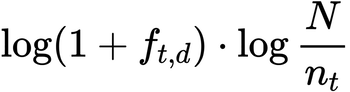

In [10]:
# TODO: what is the TF-IDF relevance for each query/page?

def tf(keyword, page, inverted_index, page_statistics):
  """
  return the term frequency of a given keyword in a given page
  """
  if keyword not in inverted_index:
    return 0
  # the method get returns a default value if the key does not exist
  tf = inverted_index[keyword].get(page, 0) / ( page_statistics[page] )

  return tf

def idf(keyword, inverted_index, page_statistics):
  idf = len(page_statistics)  / len(inverted_index[keyword])
  return idf

query = ['the', 'white', 'rose']
#page = ('Fables', 3)
#page = ('Alice', 14)

results = set()

for keyword in query:
  results.update(inverted_index[keyword])

print("Found {} results".format(len(results)))
ranked_results = []

for page in results: # for each page compute its score
  _score = 0.0

  for keyword in query:  # compute TF-IDF of a single word
    _tf = tf(keyword, page, inverted_index, page_statistics)
    _idf = idf(keyword, inverted_index, page_statistics)

    tf_idf =  math.log(1 + _tf )*math.log( _idf )
    _score += tf_idf  # here score is the sum of TF-IDF scores <- naive!
  ranked_results.append((page,_score))

  #print(page,_score)

# we rank ech result by its score, in descending order
# return top 10
sorted(ranked_results, key=lambda x: -x[1])[:10]

Found 307 results


[(('Fables', 239), 0.13953589200870134),
 (('Fables', 76), 0.048937928158690844),
 (('Fables', 26), 0.04396264045862596),
 (('Alice', 15), 0.039789610803451204),
 (('Fables', 154), 0.035738752778640914),
 (('Alice', 16), 0.027996462022130804),
 (('Fables', 219), 0.019013727449111232),
 (('Alice', 8), 0.013401616632604814),
 (('Alice', 14), 0.010784895629103433),
 (('Alice', 10), 0.008997376176754415)]

In [27]:
print(fables_pages[239])

the rose and the amaranth a rose and an amaranth blossomed side by side in a garden, and the amaranth said to her neighbour, "how i envy you your beauty and your sweet scent! no wonder you are such a universal favourite." but the rose replied with a shade of sadness in her voice, "ah, my dear friend, i bloom but for a time: my petals soon wither and fall, and then i die. but your flowers never fade, even if they are cut; for they are everlasting."


## Using BM25

In [12]:
from rank_bm25 import BM25Okapi

all_pages = []
all_pages.extend([ ('Alice', idx, content) for idx, content in enumerate(alice_pages)] )
all_pages.extend([ ('Fables', idx, content) for idx, content in enumerate(fables_pages)] )


bm25_index = BM25Okapi([_page[2].split(" ") for _page in all_pages])

query = "the white rabbit"
tokenized_query = query.split(" ")

# get_scores assigns a score to each and every page
doc_scores = bm25_index.get_scores(tokenized_query)
print([ (id, score) for id, score in  enumerate(doc_scores) if score > 0 ])

# instead of using get_scores, we return only yhe topk with get_top_n
bm25_index.get_top_n(tokenized_query, all_pages, n=1)

[(0, 2.4794041816524928), (1, 2.087876596151511), (2, 2.497518266677844), (7, 8.290159110343623), (8, 8.552449114812205), (9, 2.7488072165437027), (10, 9.31323646705312), (11, 2.666518140338405), (12, 2.7887365292648405), (13, 2.814415880783713), (14, 6.486957987471668), (15, 13.10355777000245), (16, 8.642125333001006), (17, 2.6229494212428186), (18, 2.7577535047491715), (19, 2.5043622739755764), (20, 2.105546597717835), (22, 4.2360344291558985), (23, 2.9955412039069507), (24, 2.9884876533600524), (26, 2.3485511353616193), (27, 2.5892632613183286), (28, 2.647284542857337), (29, 2.5032144202834377), (30, 2.5389789144097312), (31, 2.7092653943388303), (32, 2.7678712444680755), (33, 2.602605747667064), (34, 2.713698124021439), (35, 2.6027268060202666), (36, 2.7535870046119224), (37, 2.6871451368208414), (38, 2.7824612919598875), (39, 2.6164942176170523), (40, 2.6293733297818265), (41, 2.489558057931246), (42, 2.8094339798927233), (43, 2.7351016592136026), (44, 2.715469808889534), (45, 2.7

[('Alice',
  15,
  'ix--who stole the tarts? the king and queen of hearts were seated on their throne when they arrived, with a great crowd assembled about them--all sorts of little birds and beasts, as well as the whole pack of cards: the knave was standing before them, in chains, with a soldier on each side to guard him; and near the king was the white rabbit, with a trumpet in one hand and a scroll of parchment in the other. in the very middle of the court was a table, with a large dish of tarts upon it. "i wish they\'d get the trial done," alice thought, "and hand \'round the refreshments!" the judge, by the way, was the king and he wore his crown over his great wig. "that\'s the jury-box," thought alice; "and those twelve creatures (some were animals and some were birds) i suppose they are the jurors." just then the white rabbit cried out "silence in the court!" "herald, read the accusation!" said the king. [illustration] on this, the white rabbit blew three blasts on the trumpet,